In [30]:
import scipy.io
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
from Solver import nummodel,nummodel_flux, nummodel_jac, explicit_solve, implicit_solve
from NeuralNet import *
from timeit import default_timer



In [31]:
def permeability_ref(q, dq):
    return np.sqrt(q**2 + dq**2) 
def D_permeability_ref(q, dq):
    return q/np.sqrt(q**2 + dq**2), dq/np.sqrt(q**2 + dq**2)


# Training a quadratic function
 $$D(\theta) = \sqrt{\theta^2 + (\frac{\partial \theta}{\partial x})^2}$$

In [32]:
nn_save_name = "quadratic.nn"
N_train_1d = 100
L_train_1d = 1
N_train = N_train_1d**2

x_train_1d = np.linspace(-L_train_1d, L_train_1d, N_train_1d)
X_train_2d, Y_train_2d = np.meshgrid(x_train_1d, x_train_1d)


x_train = np.vstack((X_train_2d.reshape(-1), Y_train_2d.reshape(-1))).T
y_train = permeability_ref(x_train[:, 0], x_train[:, 1]).reshape((N_train, 1))
    
x_train = torch.from_numpy(x_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))

ind = x_train.shape[1]
outd = y_train.shape[1] 

learning_rate = 0.001
step_size = 100
gamma = 0.5  
epochs = 1000
batch_size = 64

layers = 2
width  = 20
nn_model = FNN(ind, outd, layers, width) 

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

optimizer = Adam(nn_model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = torch.nn.MSELoss(reduction='sum')
t0 = default_timer()
for ep in range(epochs):
    nn_model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:

        optimizer.zero_grad()
        out = nn_model(x)
        
        loss = myloss(out , y)*100
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()

    if ep % 100 == 0:
        # train_l2/= ntrain
        t2 = default_timer()
        print("Epoch : ", ep, " Epoch time : ", t2-t1, " Train L2 Loss : ", train_l2)
    if nn_save_name is not None:
        torch.save(nn_model, nn_save_name)
        


Epoch :  0  Epoch time :  0.22122623212635517  Train L2 Loss :  108075.51219177246
Epoch :  100  Epoch time :  0.19253484345972538  Train L2 Loss :  7.668621674180031
Epoch :  200  Epoch time :  0.1927038449794054  Train L2 Loss :  6.94255231320858
Epoch :  300  Epoch time :  0.18238694593310356  Train L2 Loss :  6.53183205332607
Epoch :  400  Epoch time :  0.20996396988630295  Train L2 Loss :  6.263556685298681
Epoch :  500  Epoch time :  0.19825206696987152  Train L2 Loss :  6.187446367926896
Epoch :  600  Epoch time :  0.21178515441715717  Train L2 Loss :  6.148209662176669
Epoch :  700  Epoch time :  0.20731712877750397  Train L2 Loss :  6.123308488633484
Epoch :  800  Epoch time :  0.1939982082694769  Train L2 Loss :  6.098314584232867
Epoch :  900  Epoch time :  0.17468936182558537  Train L2 Loss :  6.091338632628322


# Testing on the quadratic function

In [33]:
N_test_1d = 200
L_test_1d = 1
N_test = N_test_1d**2

x_test_1d = np.linspace(-L_test_1d, L_test_1d, N_test_1d)
X_test_2d, Y_test_2d = np.meshgrid(x_test_1d, x_test_1d)

x_test = np.vstack((X_test_2d.reshape(-1), Y_test_2d.reshape(-1))).T    
y_test = permeability_ref(x_test[:, 0], x_test[:, 1]).reshape((N_test, 1))



x_test = torch.from_numpy(x_test.astype(np.float32))
y_pred = nn_model(x_test).detach().numpy()



/tmp/ipykernel_257236/4190918090.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X_test_2d, Y_test_2d, y_test_2d)
/tmp/ipykernel_257236/4190918090.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X_test_2d, Y_test_2d, y_pred_2d)
/tmp/ipykernel_257236/4190918090.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrila

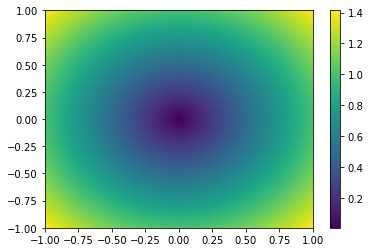

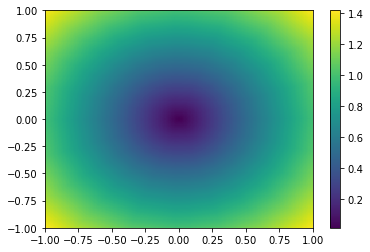

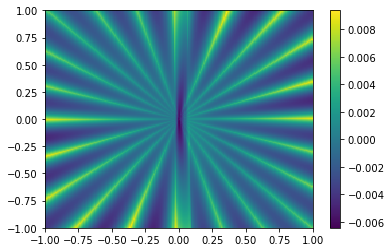

In [34]:
y_test_2d = y_test.reshape((N_test_1d,N_test_1d))
y_pred_2d = y_pred.reshape((N_test_1d,N_test_1d))

plt.figure()
plt.pcolormesh(X_test_2d, Y_test_2d, y_test_2d)
plt.colorbar()

plt.figure()
plt.pcolormesh(X_test_2d, Y_test_2d, y_pred_2d)
plt.colorbar()

plt.figure()
plt.pcolormesh(X_test_2d, Y_test_2d, y_test_2d - y_pred_2d)
plt.colorbar()

# Derivative test

In [35]:
q = np.array([1.0])
dq = np.array([1.0])
x = torch.from_numpy((np.vstack((q, dq)).T).astype(np.float32))  
x.requires_grad = True
y = nn_model(x)  #.detach().numpy().flatten()

d = torch.autograd.grad(y, x)

print("analytical derivative is :", d)
eps = 1e-3
xp0 = x + torch.Tensor([eps, 0.0])
yp0 = nn_model(xp0)
xp1 = x + torch.Tensor([0.0, eps])
yp1 = nn_model(xp1)

print("FD derivative is :", (yp0-y)/eps, (yp1-y)/eps)


analytical derivative is : (tensor([[0.7145, 0.4867]]),)
FD derivative is : tensor([[0.7145]], grad_fn=<DivBackward0>) tensor([[0.4867]], grad_fn=<DivBackward0>)


# Plug-in test

/tmp/ipykernel_257236/4291480866.py:4: RuntimeWarning: invalid value encountered in true_divide
  return q/np.sqrt(q**2 + dq**2), dq/np.sqrt(q**2 + dq**2)
/home/dzhuang/miniconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


100 max q:  nan  L2 res:  nan
200 max q:  nan  L2 res:  nan
100 max q:  0.7053671815988659  L2 res:  26856954.14530253
200 max q:  0.16930157562025716  L2 res:  213479.66532760655


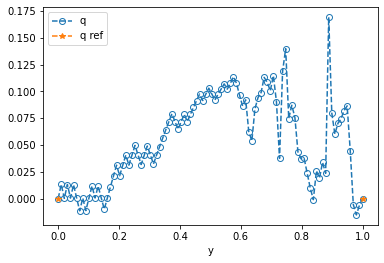

In [42]:
def permeability(q, dq):
    
    x = np.vstack((q, dq)).T
    
    permeability = nn_model(torch.from_numpy(x.astype(np.float32))).detach().numpy().flatten()
    
    return permeability

def D_permeability(q, dq):
    
    Ny = q.size
    Dq, Ddq = np.zeros(Ny), np.zeros(Ny)
    
    for i in range(Ny):
        x = torch.from_numpy(np.array([[q[i],dq[i]]]).astype(np.float32))
        x.requires_grad = True
        y = nn_model(x)  #.detach().numpy().flatten()
        d = torch.autograd.grad(y, x)[0].numpy().flatten()
        Dq[i], Ddq[i] = d[0], d[1]
    
    
    return Dq, Ddq

L = 1.0
Ny = 100
yy = np.linspace(0.0, L, Ny)
f = 6*(1-2*yy)**2 - 2*(yy - yy**2)*(1 - 2*yy)**2 + 2*(yy - yy**2)**2 + 2 
q_sol = -yy*(yy - 1)
dbc = np.array([0.0, 0.0]) 

MODEL = "exp_nummodel"

if MODEL == "exp_nummodel":
    
    model = lambda q, yy, res : nummodel(permeability_ref, q, yy, res)
    yy, t_data_ref, q_data_ref = explicit_solve(model, f, dbc, dt = 2.0e-6, Nt = 500000, save_every = 100000, L = L)

    model = lambda q, yy, res : nummodel(permeability, q, yy, res)
    yy, t_data, q_data = explicit_solve(model, f, dbc, dt = 2.0e-6, Nt = 500000, save_every = 100000, L = L)

elif MODEL == "imp_nummodel":
    
    model = lambda q, yy, res, V : nummodel_jac(permeability_ref, q, yy, res, V, True, D_permeability_ref)  
    yy_ref, t_data_ref, q_data_ref = implicit_solve(model, f, dbc, dt = 1.0e-3, Nt = 200, save_every = 100, L = L)
    
    model = lambda q, yy, res, V : nummodel_jac(permeability, q, yy, res, V, True, D_permeability)  
    yy, t_data, q_data = implicit_solve(model, f, dbc, dt = 1.0e-3, Nt = 200, save_every = 100, L = L)
    
elif MODEL == "imp_Newton_nummodel":
    
    model = lambda q, yy, res, V : nummodel_jac(permeability_ref, q, yy, res, V, True, D_permeability_ref)  
    yy_ref, t_data_ref, q_data_ref = implicit_Newton_solve(model, f, dbc, dt = 1.0e-3, Nt = 200, save_every = 100, L = L, Newton_eps = 1e-3, Newton_maxiterstep = 1000)
    
    model = lambda q, yy, res, V : nummodel_jac(permeability, q, yy, res, V, True, D_permeability)  
    yy, t_data, q_data = implicit_Newton_solve(model, f, dbc, dt = 1.0e-3, Nt = 200, save_every = 100, L = L, Newton_eps = 1e-3, Newton_maxiterstep = 1000)
    
else:
    print("ERROR")


plt.figure()
plt.plot(yy, q_data[-1, :],  "--o", fillstyle="none", label="q")
plt.plot(yy, q_data_ref[-1, :],  "--*", label="q ref")

plt.xlabel("y")
plt.legend()
plt.show()


 



# Training the flux function
 $$D(\theta) = \sqrt{\theta^2 + (\frac{\partial \theta}{\partial x})^2} \frac{\partial \theta}{\partial x}$$

In [37]:
def flux_ref(q, dq):
    return np.sqrt(q**2 + dq**2)*dq
def D_flux_ref(q, dq):
    return q/np.sqrt(q**2 + dq**2)*dq, dq/np.sqrt(q**2 + dq**2)*dq + np.sqrt(q**2 + dq**2)

In [38]:
nn_save_name = "flux.nn"
N_train_1d = 100
L_train_1d = 1
N_train = N_train_1d**2

x_train_1d = np.linspace(-L_train_1d, L_train_1d, N_train_1d)
X_train_2d, Y_train_2d = np.meshgrid(x_train_1d, x_train_1d)


x_train = np.vstack((X_train_2d.reshape(-1), Y_train_2d.reshape(-1))).T
y_train = flux_ref(x_train[:, 0], x_train[:, 1]).reshape((N_train, 1))
    
x_train = torch.from_numpy(x_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))

ind = x_train.shape[1]
outd = y_train.shape[1] 

learning_rate = 0.001
step_size = 100
gamma = 0.5  
epochs = 1000
batch_size = 64

layers = 2
width  = 20
nn_model = FNN(ind, outd, layers, width) 

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

optimizer = Adam(nn_model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = torch.nn.MSELoss(reduction='sum')
t0 = default_timer()
for ep in range(epochs):
    nn_model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:

        optimizer.zero_grad()
        out = nn_model(x)
        
        loss = myloss(out , y)*100
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()

    if ep % 100 == 0:
        # train_l2/= ntrain
        t2 = default_timer()
        print("Epoch : ", ep, " Epoch time : ", t2-t1, " Train L2 Loss : ", train_l2)
    if nn_save_name is not None:
        torch.save(nn_model, nn_save_name)
        


Epoch :  0  Epoch time :  0.2070893831551075  Train L2 Loss :  471434.3066101074
Epoch :  100  Epoch time :  0.20204011350870132  Train L2 Loss :  156.67557153105736
Epoch :  200  Epoch time :  0.2110135331749916  Train L2 Loss :  103.05789436399937
Epoch :  300  Epoch time :  0.1979946531355381  Train L2 Loss :  92.27531036734581
Epoch :  400  Epoch time :  0.2031420785933733  Train L2 Loss :  82.59781999886036
Epoch :  500  Epoch time :  0.20992277190089226  Train L2 Loss :  80.00524641573429
Epoch :  600  Epoch time :  0.19541815668344498  Train L2 Loss :  78.81120228022337
Epoch :  700  Epoch time :  0.20335694402456284  Train L2 Loss :  77.64205650985241
Epoch :  800  Epoch time :  0.19175021350383759  Train L2 Loss :  76.83978702127934
Epoch :  900  Epoch time :  0.17214234545826912  Train L2 Loss :  76.55376551300287
Epoch :  1000  Epoch time :  0.178099162876606  Train L2 Loss :  76.42506405711174
Epoch :  1100  Epoch time :  0.20716658234596252  Train L2 Loss :  76.36292009055

In [39]:
N_test_1d = 200
L_test_1d = 1
N_test = N_test_1d**2

x_test_1d = np.linspace(-L_test_1d, L_test_1d, N_test_1d)
X_test_2d, Y_test_2d = np.meshgrid(x_test_1d, x_test_1d)

x_test = np.vstack((X_test_2d.reshape(-1), Y_test_2d.reshape(-1))).T    
y_test = flux_ref(x_test[:, 0], x_test[:, 1]).reshape((N_test, 1))



x_test = torch.from_numpy(x_test.astype(np.float32))
y_pred = nn_model(x_test).detach().numpy()



/tmp/ipykernel_257236/4190918090.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X_test_2d, Y_test_2d, y_test_2d)
/tmp/ipykernel_257236/4190918090.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X_test_2d, Y_test_2d, y_pred_2d)
/tmp/ipykernel_257236/4190918090.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrila

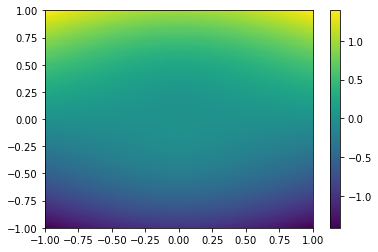

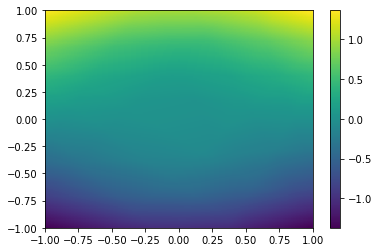

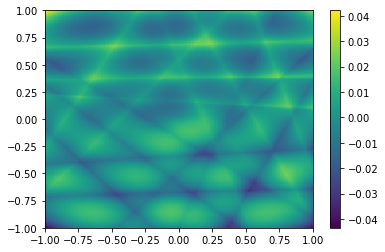

In [40]:
y_test_2d = y_test.reshape((N_test_1d,N_test_1d))
y_pred_2d = y_pred.reshape((N_test_1d,N_test_1d))

plt.figure()
plt.pcolormesh(X_test_2d, Y_test_2d, y_test_2d)
plt.colorbar()

plt.figure()
plt.pcolormesh(X_test_2d, Y_test_2d, y_pred_2d)
plt.colorbar()

plt.figure()
plt.pcolormesh(X_test_2d, Y_test_2d, y_test_2d - y_pred_2d)
plt.colorbar()

100000 max q 0.3612968630051589
200000 max q 0.3833724143438851
300000 max q 0.3838681017323774
400000 max q 0.3838789824417029
500000 max q 0.38387922115718404
100000 max q 0.3643552252642053
200000 max q 0.39037975790103896
300000 max q 0.3912595122981365
400000 max q 0.39128859401347343
500000 max q 0.3912895597050481


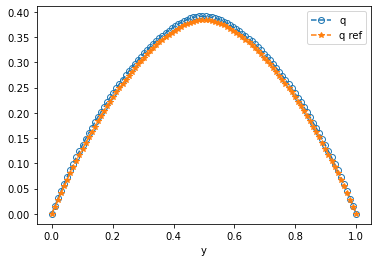

In [41]:
def flux(q, dq):
    
    x = np.vstack((q, dq)).T
    
    permeability = nn_model(torch.from_numpy(x.astype(np.float32))).detach().numpy().flatten()
    
    return permeability

def D_flux(q, dq):
    
    Ny = q.size
    Dq, Ddq = np.zeros(Ny), np.zeros(Ny)
    
    for i in range(Ny):
        x = torch.from_numpy(np.array([[q[i],dq[i]]]).astype(np.float32))
        x.requires_grad = True
        y = nn_model(x)  #.detach().numpy().flatten()
        d = torch.autograd.grad(y, x)[0].numpy().flatten()
        Dq[i], Ddq[i] = d[0], d[1]
    
    
    return Dq, Ddq

L = 1.0
Ny = 100
yy = np.linspace(0.0, L, Ny)
f = 6*(1-2*yy)**2 - 2*(yy - yy**2)*(1 - 2*yy)**2 + 2*(yy - yy**2)**2 + 2 
q_sol = -yy*(yy - 1)
dbc = np.array([0.0, 0.0]) 

MODEL = "exp_nummodel"

if MODEL == "exp_nummodel":
    
    model = lambda q, yy, res : nummodel_flux(flux_ref, q, yy, res)
    yy, t_data_ref, q_data_ref = explicit_solve(model, f, dbc, dt = 2.0e-6, Nt = 500000, save_every = 100000, L = L)

    model = lambda q, yy, res : nummodel_flux(flux, q, yy, res)
    yy, t_data, q_data = explicit_solve(model, f, dbc, dt = 2.0e-6, Nt = 500000, save_every = 100000, L = L)

else:
    print("ERROR")


plt.figure()
plt.plot(yy, q_data[-1, :],  "--o", fillstyle="none", label="q")
plt.plot(yy, q_data_ref[-1, :],  "--*", label="q ref")

plt.xlabel("y")
plt.legend()
plt.show()